## Importing all necessary libraries

In [1]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')


## Data Understanding

### Loading Datasets from Csv file

In [2]:
train_df = pd.read_csv('../data/raw/train_v9rqX0R.csv')
test_df = pd.read_csv('../data/raw/test_AbJTz2l.csv')
print("The shape of training dataset is {}".format(train_df.shape))
print("The shape of testing dataset is {}".format(test_df.shape))

The shape of training dataset is (8523, 12)
The shape of testing dataset is (5681, 11)


### Combining Training & Testing Dataframe For Handling Missing Values

In [3]:
combined_df = pd.concat([train_df, test_df], axis = 0)
combined_df.columns= combined_df.columns.str.lower()
print("The shape of dataset after combining training and testing dataset is {}".format(combined_df.shape))

The shape of dataset after combining training and testing dataset is (14204, 12)


### Function To Check Missing Values

In [4]:
def check_missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

## Function To Visualize Missing Values Using Seaborn

In [5]:
def visualize_missing_values(df):
    
    plt.figure(figsize=(8,8))
    plt.title('Visualizing Missing Values')
    sns.heatmap(df.isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
    plt.show()

## Data Cleaning

In [6]:
check_missing_values(combined_df)

,Missing_Number,Missing_Percent
item_outlet_sales,5681,39.995776
outlet_size,4016,28.273726
item_weight,2439,17.171219
outlet_type,0,0.000000
outlet_location_type,0,0.000000
outlet_identifier,0,0.000000
outlet_establishment_year,0,0.000000
item_visibility,0,0.000000
item_type,0,0.000000
item_mrp,0,0.000000


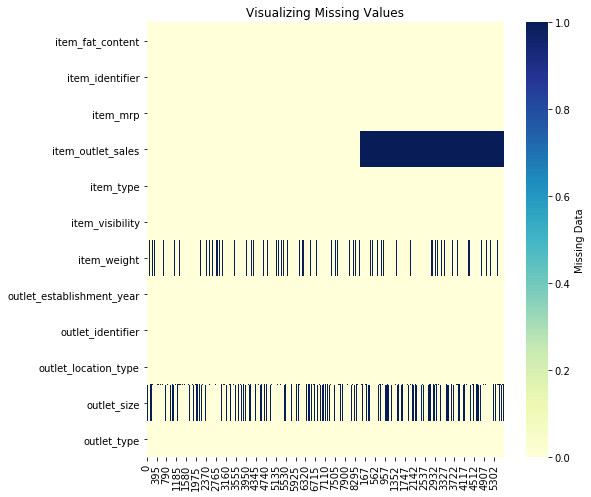

In [7]:
visualize_missing_values(combined_df)

<li><b>We have 2439 missing values in 'item_weight' column which is 17.17% of the whole datasets</li></b>

<li><b>We have 4016 missing values in 'outlet_size' column which is 28.27% of the whole datasets</li></b>

<li><b>We have 5681 missing values in 'item_weight' column which is around 40% of the whole datasets. This column is a target column.</li></b>


<li><b>So, we don't need to handle missing values of the target column but we will need to handle missing values of other two columns.</b></li>

<li><b>Let's see whether there are any patterns that exists in our missing values.</b></li>



### Handling missing values in 'item_weight' column

**<li>The weight of a particular item in a store or mart is always same.</li>**
**<li>For example, if item with id "DRE01" is Oreo Biscuit, then it's weight is always same for all item outlet combinations.</li>**
**<li>So, we can use this information to fill the missing values for this column.</li>**

In [8]:
print(combined_df.loc[combined_df['item_weight'].isnull(), "item_identifier"].nunique())
print(combined_df.loc[~combined_df['item_weight'].isnull(), "item_identifier"].nunique())

1559
1559


In [9]:
for item in tqdm(combined_df['item_identifier'].unique()):
    combined_df.loc[(combined_df['item_identifier'] == item) & 
                    (combined_df['item_weight'].isnull()), "item_weight"] = \
    combined_df.loc[combined_df['item_identifier'] == item, "item_weight"].mean()

100%|██████████| 1559/1559 [00:03<00:00, 417.79it/s]


### Handling Missing values in 'outlet_size' column

**<li>The size of an outlet depends on the type and the location of a outlet.</li>**
**<li>For example, if the outlet type is minimart then the size of the outlet can be small.</li>**
**<li>For example,the outlet situated in remote area is likely to be small size outlet but that situated in capital can be large size outlet.</li>**
**<li>So, we can use such metadata of outlets to fill the missing values for this column.</li>**

In [10]:
print("There are {} unique outlet types. They are: \n {}"
      .format(combined_df["outlet_type"].nunique(),
      combined_df["outlet_type"].unique().tolist()))

print("Out of {} outlet types, {} of them have missing values in outlet size.".
      format(combined_df["outlet_type"].nunique(),
             combined_df.loc[combined_df['outlet_size'].isnull(),"outlet_type"].nunique()))

print("They are: {}".format(combined_df.loc[combined_df['outlet_size'].isnull(),"outlet_type"].unique().tolist()))

There are 4 unique outlet types. They are: 
 ['Supermarket Type1', 'Supermarket Type2', 'Grocery Store', 'Supermarket Type3']
Out of 4 outlet types, 2 of them have missing values in outlet size.
They are: ['Grocery Store', 'Supermarket Type1']


### Let's handle missing values for outletsize when outlet type is Grocery Store

In [11]:
combined_df.loc[combined_df['outlet_type'] == "Grocery Store", "outlet_size"].value_counts()

Small    880
Name: outlet_size, dtype: int64

**<li>All Grocery Stores (outlet type) have small size outlets.</li>**
**<li>So, we can fill the missing outlet size values for those outlets which correspond to Grocery Store with Small.</li>**

In [12]:
combined_df.loc[combined_df['outlet_type'] == "Grocery Store", "outlet_size"] = "Small"

### Let's handle missing values for 'outlet_size' when outlet type is Supermarket Type1

In [13]:
combined_df.loc[combined_df['outlet_type'] == "Supermarket Type1", "outlet_size"].value_counts()

Small     3100
High      1553
Medium    1550
Name: outlet_size, dtype: int64

**<li>So, outlet type only cannot be used to fill missing values for outlet size.</li>**
**<li>The Supermarket Type 1 outlet has all three variations of outlet when it comes to size.</li>**
**<li>So, let's use both outlet type and outlet location type to fill the missing values for outlet size.</li>**

In [14]:
combined_df.loc[(combined_df['outlet_size'].isnull()) & (combined_df['outlet_type']== "Supermarket Type1"), "outlet_location_type"].value_counts()

Tier 2    3091
Name: outlet_location_type, dtype: int64

In [15]:
combined_df.loc[combined_df['outlet_location_type'] == "Tier 2", "outlet_size"].value_counts()

Small    1550
Name: outlet_size, dtype: int64

**<li>For all outlet types that belong to Supermarket Type1 and have missing values in outlet size is located in Tier2 outlet location type.</li>**
**<li>For all outlets whose location type is "Tier 2" they have small outlet size.</li>**
**<li>So, we can fill the missing outlet size values for those outlets whose outlet location type correspond to Tier 2 with Small.</li>**

In [16]:
combined_df.loc[(combined_df['outlet_type']== "Supermarket Type1") &
                (combined_df['outlet_location_type'] == "Tier 2")  &
                (combined_df['outlet_size'].isnull()), "outlet_size"] = "Small"

### Item_Fat_Content column

In [17]:
combined_df['item_fat_content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: item_fat_content, dtype: int64

**<li>We have five unique values in "Item_Fat_Content" column.</li>**
**<li>But when we observe its values, we can only relate it to 2 different values rather than 5.</li>**
**<li>'Low Fat', 'LF', 'low fat' all refers to items with low fat content.</li>**
**<li>"reg", "Regular" both refers to items with regular fat content.</li>**
**<li>So, replacing other values which represents same information are converted to either of these 2 values.</li>**

In [18]:
combined_df.loc[combined_df['item_fat_content'] == "LF", "item_fat_content"] = "Low Fat"
combined_df.loc[combined_df['item_fat_content'] == "low fat", "item_fat_content"] = "Low Fat"
combined_df.loc[combined_df['item_fat_content'] == "reg", "item_fat_content"] = "Regular"

### Item Visibility Column

In [19]:
combined_df.loc[combined_df['item_visibility'] == 0].shape

(879, 12)

**<li>We can see that there are 879 rows where item visibility seems to be 0.</li>**
**<li>Item visibility cannot be 0 because a store keeper allocates a certain area to store a particular product.</li>**
**<li>We also find out that some items which have certain visibility in some rows has 0 visibility in some rows.</li>** 

In [20]:
combined_df.loc[combined_df['item_identifier'] == "FDY07"]

,item_fat_content,item_identifier,item_mrp,item_outlet_sales,item_type,item_visibility,item_weight,outlet_establishment_year,outlet_identifier,outlet_location_type,outlet_size,outlet_type
10,Low Fat,FDY07,45.5402,1516.0266,Fruits and Vegetables,0.000000,11.8,1999,OUT049,Tier 1,Medium,Supermarket Type1
651,Low Fat,FDY07,46.5402,229.7010,Fruits and Vegetables,0.000000,11.8,1998,OUT010,Tier 3,Small,Grocery Store
779,Low Fat,FDY07,46.8402,597.2226,Fruits and Vegetables,0.121848,11.8,2002,OUT045,Tier 2,Small,Supermarket Type1
3370,Low Fat,FDY07,46.3402,275.6412,Fruits and Vegetables,0.122290,11.8,2007,OUT017,Tier 2,Small,Supermarket Type1
4208,Low Fat,FDY07,45.9402,872.8638,Fruits and Vegetables,0.000000,11.8,1985,OUT027,Tier 3,Medium,Supermarket Type3
4791,Low Fat,FDY07,45.2402,1148.5050,Fruits and Vegetables,0.000000,11.8,2009,OUT018,Tier 3,Medium,Supermarket Type2
6321,Low Fat,FDY07,46.8402,413.4618,Fruits and Vegetables,0.121501,11.8,1987,OUT013,Tier 3,High,Supermarket Type1
4443,Low Fat,FDY07,44.1402,NaN,Fruits and Vegetables,0.000000,11.8,2004,OUT035,Tier 2,Small,Supermarket Type1
4736,Low Fat,FDY07,45.5402,NaN,Fruits and Vegetables,0.000000,11.8,1997,OUT046,Tier 1,Small,Supermarket Type1


**<li>Here we can notice that the item (FDY07) has visibility of around 0.12 in 3 rows and also has visibility of 0 in other 6 rows.</li>**
**<li>This seems to be error while manually storing the data.</li>**
**<li>Similar cases were reported for other items as well.</li>**
**<li>So, let's replace such value with the mean visibility of a particular item.</li>**

In [21]:
for item in tqdm(combined_df['item_identifier'].unique()):
    combined_df.loc[(combined_df['item_identifier'] == item) & 
                    (combined_df['item_visibility'] == 0), "item_visibility"] = \
    combined_df.loc[combined_df['item_identifier'] == item, "item_visibility"].mean()

100%|██████████| 1559/1559 [00:03<00:00, 419.72it/s]


### Feature Engineering

In [22]:
def cal_count(df,groupby_col, target_col, gen_cols):
    
    new_df = df.groupby(groupby_col)[target_col].agg('count').to_frame().reset_index()
    new_df.columns = gen_cols
    df = pd.merge(df, new_df, on = groupby_col, how = "inner")
    return df
    

In [23]:
def cal_statistical_features(df, groupby_col, target_col):
    

    mean_df = df.groupby(groupby_col)[target_col].mean().to_frame().reset_index()
    mean_df.columns = [groupby_col, "avg_" + target_col + "_wrt_" + groupby_col]
    df = pd.merge(df, mean_df, how = "inner", on = groupby_col)

    
    std_df = df.groupby(groupby_col)[target_col].std().to_frame().reset_index()
    std_df.columns = [groupby_col, "std_" + target_col + "_wrt_" + groupby_col]
    df = pd.merge(df, std_df, how = "inner", on = groupby_col)


    return df

#### Generating Count Features

In [24]:
# combined_df = cal_count(df = combined_df,groupby_col = "item_identifier", 
#                         target_col = "outlet_identifier", 
#                         gen_cols = ["item_identifier", "no_of_outlets_allocated_for_each_item"])

#### Generating Statistical Features

In [25]:
combined_df = cal_statistical_features(df = combined_df, groupby_col = "outlet_identifier", 
                                       target_col = "item_outlet_sales")


#### Label Encoding outlet_location_type

In [26]:
outlet_location_type_dict = {"Tier 1": 1, "Tier 2": 2, "Tier 3": 3}
combined_df=combined_df.replace({"outlet_location_type": outlet_location_type_dict})

#### Label Encoding outlet_size

In [27]:
outlet_size_dict = {"Small": 1, "Medium": 2, "High": 3}
combined_df=combined_df.replace({"outlet_size": outlet_size_dict})

#### Label Encoding outlet_type

In [28]:
outlet_type_dict = {"Grocery Store": 1, "Supermarket Type1": 2, "Supermarket Type2": 3, "Supermarket Type3": 4}
combined_df=combined_df.replace({"outlet_type": outlet_type_dict})

### Generating new features using item_mrp feature

**<li>Item Mrp Per Weight</li>**
**<li>Item Mrp Per Visibility</li>**
**<li>Age of the outlet from it's establishment year. Since data is from 2013 so subtracting 2013 from establishment year gives the age of the outlet</li>**

In [29]:
combined_df['item_mrp_per_weight'] = combined_df['item_mrp'] / combined_df['item_weight']
combined_df['item_mrp_per_visibility'] = combined_df['item_mrp'] / combined_df['item_visibility']
combined_df['outlet_age'] = 2013 - combined_df['outlet_establishment_year'].astype('int')
combined_df.drop('outlet_establishment_year', axis = 1, inplace = True)

**<h4>Creating New Column from item_identifier column</h4>**
<li>If we look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC.</li>
<li>If you see the categories, these look like being Food, Drinks and Non-Consumables.</li>
<li>So I’ve used the Item_Identifier variable to create a new column:</li>

In [30]:
#Get the first two characters of ID:
combined_df['item_identifier_combined'] = combined_df['item_identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
combined_df['item_identifier_combined'] = combined_df['item_identifier_combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})

#### Label Encoding item_fat_content

In [31]:
combined_df.loc[combined_df['item_identifier_combined'] == "Non-Consumable", "item_fat_content"] = "No Fat"
item_fat_content_dict = {"No Fat": 0, "Low Fat": 1, "Regular": 2}
combined_df = combined_df.replace({"item_fat_content": item_fat_content_dict})

#### One Hot Encoding item_identifier_combined column

In [32]:
# item_identifier_combined_dummies = pd.get_dummies(combined_df.item_identifier_combined)  
# item_identifier_combined_dummies.columns = ["item_" + column.lower() for column in item_identifier_combined_dummies.columns]
# print("The shape of dataset before one hot encoding item_identifier_combined column is {}".format(combined_df.shape))
# combined_df = pd.concat([combined_df, item_identifier_combined_dummies], axis = 1)
# combined_df = combined_df.drop(['item_identifier_combined', 'item_drinks'], axis = 1)
# print("The shape of dataset after one hot encoding item_identifier_combined_dummies column is {}".format(combined_df.shape))
combined_df.drop('item_identifier_combined', axis = 1, inplace = True)

#### One Hot Encoding item_type

In [33]:
item_type_dummies = pd.get_dummies(combined_df.item_type)  
item_type_dummies.columns = ["item_" + column.replace(' ', '_').lower() for column in item_type_dummies.columns]
print("The shape of dataset before one hot encoding item_type is {}".format(combined_df.shape))
combined_df = pd.concat([combined_df, item_type_dummies], axis = 1)
combined_df = combined_df.drop(['item_type', 'item_others'], axis = 1)
print("The shape of dataset after one hot encoding item_type is {}".format(combined_df.shape))


The shape of dataset before one hot encoding item_type is (14204, 16)
The shape of dataset after one hot encoding item_type is (14204, 30)


#### One Hot Encoding outlet_identifier

In [34]:
# outlet_identifier_dummies = pd.get_dummies(combined_df.outlet_identifier)  
# outlet_identifier_dummies.columns = [column.lower() for column in outlet_identifier_dummies.columns]
# print("The shape of dataset before one hot encoding outlet_identifier is {}".format(combined_df.shape))
# combined_df = pd.concat([combined_df, outlet_identifier_dummies], axis = 1)
# combined_df = combined_df.drop('out019', axis = 1)
# print("The shape of dataset after one hot encoding outlet_identifier is {}".format(combined_df.shape))

In [35]:
combined_df.corr()

,item_fat_content,item_mrp,item_outlet_sales,item_visibility,item_weight,outlet_location_type,outlet_size,outlet_type,avg_item_outlet_sales_wrt_outlet_identifier,std_item_outlet_sales_wrt_outlet_identifier,...,item_frozen_foods,item_fruits_and_vegetables,item_hard_drinks,item_health_and_hygiene,item_household,item_meat,item_seafood,item_snack_foods,item_soft_drinks,item_starchy_foods
item_fat_content,1.000000,-0.007667,0.018407,0.078096,-0.053809,0.001413,0.000899,0.000543,0.000257,0.000327,...,0.150348,0.167675,-0.036996,-0.411160,-0.567126,0.147366,0.026571,0.147308,-0.004562,0.048787
item_mrp,-0.007667,1.000000,0.567574,-0.007550,0.035751,0.000838,0.001052,0.000136,0.000321,0.000323,...,-0.024416,0.021594,-0.009664,-0.032251,0.043553,-0.002688,0.000363,0.035457,-0.020939,0.019575
item_outlet_sales,0.018407,0.567574,1.000000,-0.128453,0.013261,0.089367,0.162753,0.401522,0.490755,0.485363,...,-0.009482,0.025950,-0.003956,-0.025587,0.015701,-0.002995,0.007380,0.022782,-0.024040,0.015039
item_visibility,0.078096,-0.007550,-0.128453,1.000000,-0.022028,-0.020753,-0.090900,-0.169896,-0.246437,-0.266293,...,0.012404,0.024619,0.002029,-0.050980,-0.051656,-0.030495,0.007483,0.010615,-0.004663,0.004675
item_weight,-0.053809,0.035751,0.013261,-0.022028,1.000000,-0.001719,0.000512,0.001913,0.002546,0.002692,...,-0.016039,0.035512,-0.041189,0.018149,0.042349,-0.005139,-0.001166,0.007954,-0.050070,0.025951
outlet_location_type,0.001413,0.000838,0.089367,-0.020753,-0.001719,1.000000,0.480055,0.467251,0.182191,0.170389,...,-0.002575,0.000949,0.002829,-0.001393,0.001473,-0.000024,-0.002244,0.001630,0.000813,0.002950
outlet_size,0.000899,0.001052,0.162753,-0.090900,0.000512,0.480055,1.000000,0.401405,0.331697,0.348688,...,-0.001770,-0.000560,0.000788,0.000516,-0.001264,-0.002859,0.001791,0.003333,0.001084,0.002283
outlet_type,0.000543,0.000136,0.401522,-0.169896,0.001913,0.467251,0.401405,1.000000,0.818240,0.782587,...,-0.003537,-0.002326,0.001198,0.000483,-0.000166,-0.004443,0.002337,0.005005,0.001954,0.004445
avg_item_outlet_sales_wrt_outlet_identifier,0.000257,0.000321,0.490755,-0.246437,0.002546,0.182191,0.331697,0.818240,1.000000,0.989014,...,-0.004735,-0.003741,0.002394,0.001216,-0.000113,-0.005730,0.002966,0.007008,0.002585,0.006578
std_item_outlet_sales_wrt_outlet_identifier,0.000327,0.000323,0.485363,-0.266293,0.002692,0.170389,0.348688,0.782587,0.989014,1.000000,...,-0.005113,-0.004031,0.002604,0.001145,-0.000107,-0.006254,0.003113,0.007623,0.002826,0.007220


## Dropping highly correlated features

In [36]:
cor_matrix = combined_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(len(to_drop))
print(to_drop)

1
['std_item_outlet_sales_wrt_outlet_identifier']


In [37]:
combined_df = combined_df.drop(to_drop, axis = 1)
print(combined_df.shape)
combined_df.head()

(14204, 29)


,item_fat_content,item_identifier,item_mrp,item_outlet_sales,item_visibility,item_weight,outlet_identifier,outlet_location_type,outlet_size,outlet_type,...,item_frozen_foods,item_fruits_and_vegetables,item_hard_drinks,item_health_and_hygiene,item_household,item_meat,item_seafood,item_snack_foods,item_soft_drinks,item_starchy_foods
0,1,FDA15,249.8092,3735.1380,0.016047,9.3,OUT049,1,2,2,...,0,0,0,0,0,0,0,0,0,0
1,1,FDN15,141.6180,2097.2700,0.016760,17.5,OUT049,1,2,2,...,0,0,0,0,0,1,0,0,0,0
2,1,FDY07,45.5402,1516.0266,0.040627,11.8,OUT049,1,2,2,...,0,1,0,0,0,0,0,0,0,0
3,2,FDX32,145.4786,1589.2646,0.100014,15.1,OUT049,1,2,2,...,0,1,0,0,0,0,0,0,0,0
4,2,FDP49,54.3614,718.3982,0.069196,9.0,OUT049,1,2,2,...,0,0,0,0,0,0,0,0,0,0


## Splitting the data into training, testing and validation set

In [38]:
combined_df = combined_df.set_index(['item_identifier','outlet_identifier'])
print(combined_df.shape)
combined_df.head()

(14204, 27)


,,item_fat_content,item_mrp,item_outlet_sales,item_visibility,item_weight,outlet_location_type,outlet_size,outlet_type,avg_item_outlet_sales_wrt_outlet_identifier,item_mrp_per_weight,...,item_frozen_foods,item_fruits_and_vegetables,item_hard_drinks,item_health_and_hygiene,item_household,item_meat,item_seafood,item_snack_foods,item_soft_drinks,item_starchy_foods
item_identifier,outlet_identifier,,,,,,,,,,,,,,,,,,,,,
FDA15,OUT049,1,249.8092,3735.1380,0.016047,9.3,1,2,2,2348.354635,26.861204,...,0,0,0,0,0,0,0,0,0,0
FDN15,OUT049,1,141.6180,2097.2700,0.016760,17.5,1,2,2,2348.354635,8.092457,...,0,0,0,0,0,1,0,0,0,0
FDY07,OUT049,1,45.5402,1516.0266,0.040627,11.8,1,2,2,2348.354635,3.859339,...,0,1,0,0,0,0,0,0,0,0
FDX32,OUT049,2,145.4786,1589.2646,0.100014,15.1,1,2,2,2348.354635,9.634344,...,0,1,0,0,0,0,0,0,0,0
FDP49,OUT049,2,54.3614,718.3982,0.069196,9.0,1,2,2,2348.354635,6.040156,...,0,0,0,0,0,0,0,0,0,0


In [39]:
combined_df.columns

Index(['item_fat_content', 'item_mrp', 'item_outlet_sales', 'item_visibility',
       'item_weight', 'outlet_location_type', 'outlet_size', 'outlet_type',
       'avg_item_outlet_sales_wrt_outlet_identifier', 'item_mrp_per_weight',
       'item_mrp_per_visibility', 'outlet_age', 'item_baking_goods',
       'item_breads', 'item_breakfast', 'item_canned', 'item_dairy',
       'item_frozen_foods', 'item_fruits_and_vegetables', 'item_hard_drinks',
       'item_health_and_hygiene', 'item_household', 'item_meat',
       'item_seafood', 'item_snack_foods', 'item_soft_drinks',
       'item_starchy_foods'],
      dtype='object')

In [40]:
final_train_df = combined_df.loc[~combined_df['item_outlet_sales'].isnull()]
final_test_df = combined_df.loc[combined_df['item_outlet_sales'].isnull()]
final_test_df.drop('item_outlet_sales', axis = 1, inplace = True)

In [41]:
train_target_column = final_train_df.pop('item_outlet_sales')
# insert column using insert(position,column_name,first_column) function
final_train_df.insert(0, 'item_outlet_sales', train_target_column)

In [42]:
X = final_train_df.iloc[:, 1:]
y = final_train_df.iloc[:,0]

In [43]:
# using the train test split function
x_train, x_val,y_train, y_val = train_test_split(X,y ,
                                   random_state=42, 
                                   test_size=0.2, 
                                   shuffle=True)

### Training & Evaluating the model

In [44]:
from xgboost import XGBRegressor 
from xgboost import plot_importance, plot_tree
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [94]:
models = {
    "                   Decision Tree"      : DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(n_estimators = 50),
    "                     Gradient Boosting": GradientBoostingRegressor(alpha = 0.5,
                                   learning_rate = 0.1,
                                   n_estimators =50,
                                  max_depth = 5,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2),
    "                               XGBoost": XGBRegressor(n_estimators = 50)
}



In [95]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print(name + " trained.")
    
    
print("Model Performance\n-----------------")
for name, model in models.items():
    y_pred = model.predict(x_val)
    print(
        "\n" + name + " Rmse Score is: {:.3f}\n\t\t\t\t \
        MSE Score is: {:.3f}\n\t\t\t\t     \
        MAE Score: {:.3f}\n\t\t\t\t     \
        R2 Score: {:.3f}".format(
            math.sqrt(mean_squared_error(y_val, y_pred)) ,
            mean_squared_error(y_val, y_pred), 
            mean_absolute_error(y_val, y_pred),
            r2_score(y_val, y_pred))
    )

                   Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
Model Performance
-----------------

                   Decision Tree Rmse Score is: 1494.726
				         MSE Score is: 2234206.318
				             MAE Score: 1031.134
				             R2 Score: 0.232

                         Random Forest Rmse Score is: 1112.756
				         MSE Score is: 1238226.596
				             MAE Score: 783.285
				             R2 Score: 0.574

                     Gradient Boosting Rmse Score is: 1074.814
				         MSE Score is: 1155225.679
				             MAE Score: 756.637
				             R2 Score: 0.603

                               XGBoost Rmse Score is: 1115.325
				         MSE Score is: 1243950.296
				             MAE Score: 777.585
				             R2 Score: 0.572


## Gradient Boosting Regressor

In [116]:
gb_reg = GradientBoostingRegressor(n_estimators =50,
                                  random_state = 42)
gb_reg.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [117]:
predicted_sales = gb_reg.predict(x_val)
valid_vs_pred_df = pd.DataFrame({"item_outlet_sales":  y_val, "predicted_item_outlet_sales": predicted_sales})

In [118]:
valid_vs_pred_df.head(20)

,,item_outlet_sales,predicted_item_outlet_sales
item_identifier,outlet_identifier,,
FDS37,OUT035,1158.4920,2025.510944
NCA29,OUT013,3251.1014,2932.378274
FDI40,OUT046,2111.2518,1618.516141
NCC55,OUT018,372.8480,576.271800
FDY57,OUT049,1342.2528,1546.401248
FDN57,OUT045,1701.7848,2012.540333
FDC41,OUT010,153.1340,302.246673
DRK59,OUT018,937.4464,3201.785924
FDG59,OUT017,308.9312,706.078961


In [119]:
rmse_score = math.sqrt(mean_squared_error(valid_vs_pred_df["predicted_item_outlet_sales"],
                                          valid_vs_pred_df["item_outlet_sales"]))
print("The rmse score for total_sales is {}".format(rmse_score))

The rmse score for total_sales is 1066.6961460065738


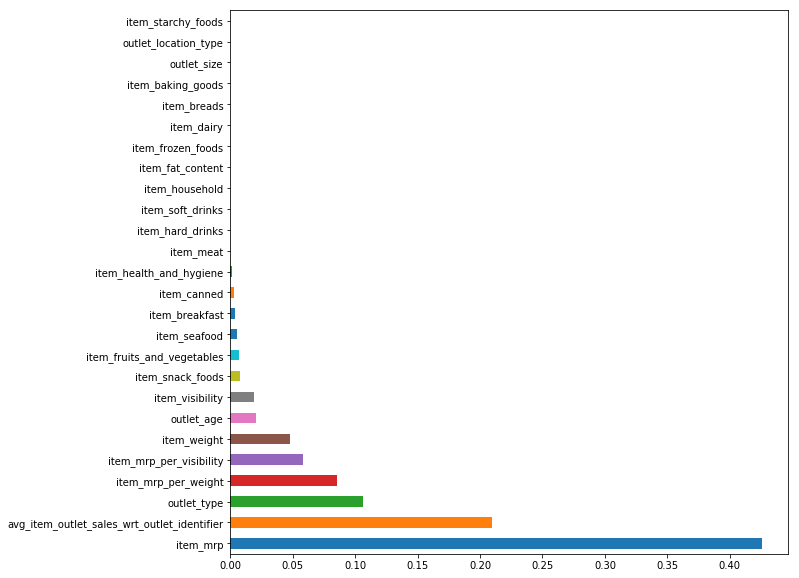

In [129]:
# gb_reg.feature_importances_
fig= plt.figure(figsize=(10, 10))
feat_importances = pd.Series(gb_reg.feature_importances_, index=X.columns)
feat_importances.nlargest(100).plot(kind='barh')
fig.savefig('feature_importances.png')

## Testing results on testing data

In [77]:
x_train_final = final_train_df.iloc[:, 1:]
y_train_final = final_train_df.iloc[:,0]
x_test_final = final_test_df

In [78]:
gb_reg = GradientBoostingRegressor(n_estimators = 50)
gb_reg.fit(x_train_final, y_train_final)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [79]:
predicted_sales_final = gb_reg.predict(x_test_final)

In [80]:
y_test_final = pd.DataFrame({"Item_Outlet_Sales": predicted_sales_final})
y_test_final.index = x_test_final.index

In [81]:
submission_df = y_test_final.reset_index()
submission_df.columns = ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']

In [82]:
submission_df.to_csv('submission_df_gbr_003.csv', index = False)